In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def show(img, title=None):
    npimg = img.numpy()
    plt.figure(dpi=200)
    if title:
        plt.title(title)
    npimg = np.transpose(npimg, (1,2,0))
    cmap = None
    if npimg.shape[-1] not in [3,4]:
        npimg = npimg[:,:,0]
        cmap = 'gray'
    plt.imshow(npimg, interpolation='nearest', cmap=cmap)

In [3]:
epochs = 0

# UTKFace Data

In [4]:
batch_size = 128

In [5]:
from data import UTKFace
dataset = UTKFace(label='gender', transform=transforms.Compose([
                    transforms.Grayscale(),
                    transforms.Resize((256, 256)), 
                    transforms.ToTensor()])
                 )

In [6]:
idcs = np.arange(len(dataset))
np.random.seed(0) # This is important to split the same way every single time
np.random.shuffle(idcs)
split_idx = int(0.9 * len(dataset))
train_idcs = idcs[:split_idx]
test_idcs = idcs[split_idx:]

In [7]:
train_dataset = torch.utils.data.Subset(dataset, train_idcs)
test_dataset = torch.utils.data.Subset(dataset, test_idcs)

### Toggle cell below for sample debugging

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, num_workers=4)
    
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=batch_size, shuffle=True, num_workers=4)

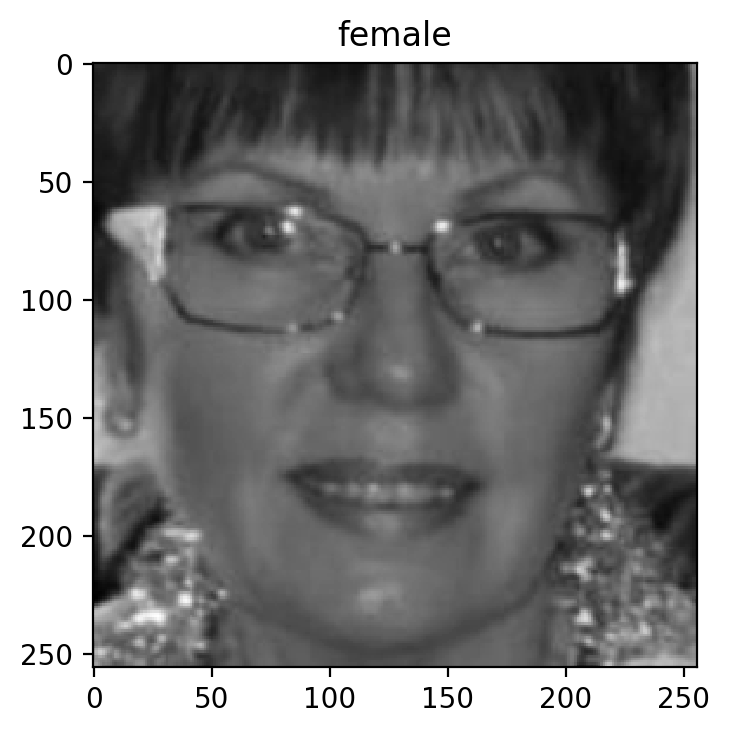

In [9]:
a_face, gender_idx = dataset[10000]
show(a_face, dataset.classes[gender_idx])

# VAE Model

In [10]:
from models import VAE

In [11]:
device = torch.device("cuda")

In [12]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, _ in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = model.loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in tqdm(enumerate(test_loader)):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += model.loss(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 256, 256)[:n]])
                show(make_grid(comparison.cpu(), nrow=n), 'Reconstruction {}'.format(epoch))

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

# Load

In [14]:
weight_path = 'weights/{}_{}.pt'.format(model.__class__.__name__, dataset.__class__.__name__)
weight_path

'weights/VAE_UTKFace.pt'

In [15]:
import os
if os.path.exists(weight_path):
    model.load_state_dict(torch.load(weight_path))  
    print("Loaded model")

Loaded model


# Train

100%|██████████| 167/167 [04:16<00:00,  1.29s/it]

====> Epoch: 1 Average loss: 38489.5086



19it [00:12,  1.66it/s]


====> Test set loss: 38433.6354
CPU times: user 2min 50s, sys: 1min 38s, total: 4min 29s
Wall time: 4min 29s


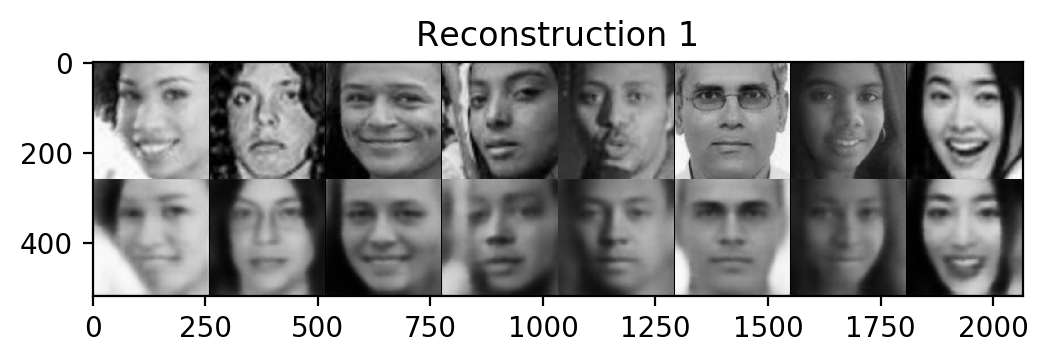

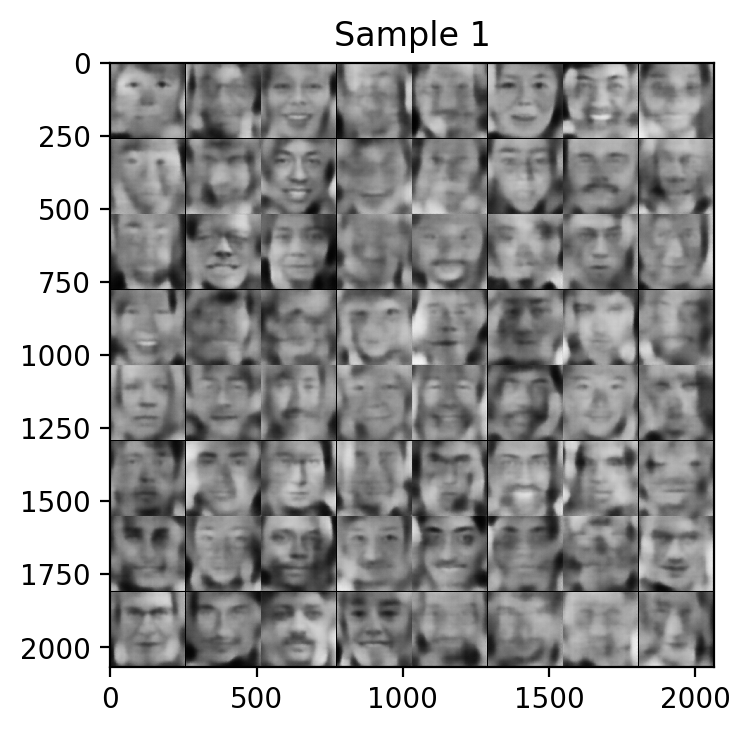

In [16]:
%%time
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 50).to(device)
        sample = model.decode(sample).cpu()
        show(make_grid(sample.view(64, 1, 256, 256)), 'Sample {}'.format(epoch))

# Evaluate

In [ ]:
test(epoch)
with torch.no_grad():
    sample = torch.randn(64, 50).to(device)
    sample = model.decode(sample).cpu()
    show(make_grid(sample.view(64, 1, 256, 256)), 'Sample {}'.format(epoch))

# Save

In [17]:
torch.save(model.state_dict(), weight_path)

In [18]:
model.eval()
torch.set_grad_enabled(False)

# Transition between average male and average female

In [19]:
avg_male_enc = torch.zeros(model.latent_space, dtype=torch.float).to(device)
avg_female_enc = torch.zeros(model.latent_space, dtype=torch.float).to(device)
num_male, num_female = 0, 0

In [20]:
dataset.classes

['female', 'male']

In [21]:
for faces, genders in tqdm(test_loader):
    faces = faces.to(device)
    encodes, _ = model.encode(faces)
    male_encodes = encodes[genders == 1]
    female_encodes = encodes[genders == 0]
    avg_male_enc += male_encodes.sum(dim=0)
    avg_female_enc += female_encodes.sum(dim=0)
    num_male += (genders == 1).sum()
    num_female += (genders == 0).sum()

avg_male_enc /= num_male
avg_female_enc /= num_female

100%|██████████| 19/19 [00:05<00:00,  4.31it/s]


In [22]:
import torchvision.utils
num_steps = 10 # num_steps = 1 -> two images
encodings = torch.empty((num_steps + 1, model.latent_space))
encodings.shape

torch.Size([11, 50])

In [23]:
curr = avg_male_enc
step_vec = (avg_female_enc - avg_male_enc) / num_steps
for i in tqdm(range(num_steps + 1)):
    encodings[i] = curr
    curr += step_vec

100%|██████████| 11/11 [00:00<00:00, 5405.66it/s]


In [24]:
decoded_faces = model.decode(encodings.to(device)).detach().cpu()

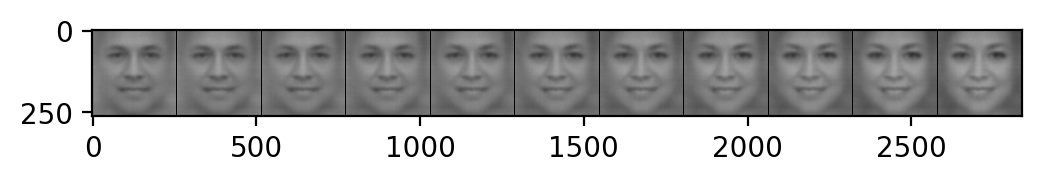

In [25]:
progressed_faces = torchvision.utils.make_grid(decoded_faces, nrow=num_steps + 1)
show(progressed_faces)

# Try it on Jenny's Face

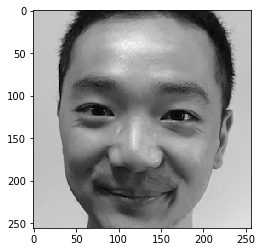

In [31]:
from skimage import io
import matplotlib.pyplot as plt
f_to_m_vec = avg_male_enc - avg_female_enc
jenny = np.expand_dims(io.imread('data/Headshots/Eddie.jpeg', as_grey=True), -1)
plt.imshow(jenny[:,:,0], cmap='gray')

In [32]:
jenny_tensor = torch.from_numpy(np.expand_dims(jenny.transpose(2,0,1), 0)).float()
encodings = torch.empty((num_steps + 1, model.latent_space))
jenny_enc, _ = model.encode(jenny_tensor.to(device))

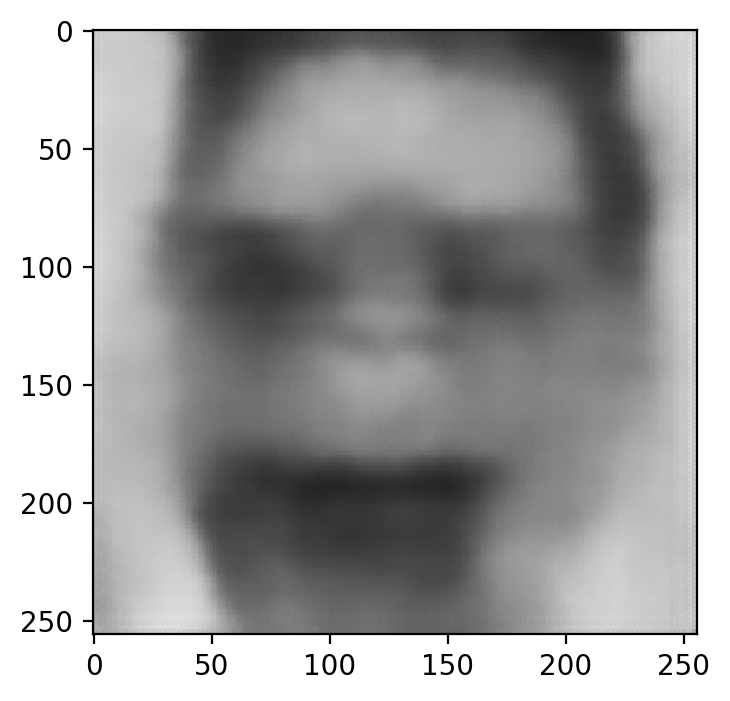

In [33]:
jenny_reconst, _, _ = model(jenny_tensor.to(device))
show(torchvision.utils.make_grid(jenny_reconst.detach().cpu()))

In [34]:
num_steps = 10
curr = jenny_enc
with torch.autograd.no_grad():
    step_vec = (f_to_m_vec) / num_steps
    for i in tqdm(range(num_steps + 1)):
        encodings[i] = curr
        curr += step_vec

100%|██████████| 11/11 [00:00<00:00, 350.87it/s]


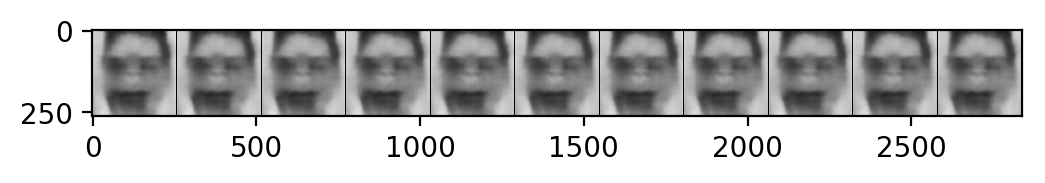

In [35]:
jenny_progressed = model.decode(encodings.to(device))
jenny_progressed = torchvision.utils.make_grid(jenny_progressed, nrow=num_steps + 1).detach().cpu()
show(jenny_progressed)